# Import modules

In [48]:
from glyconformer import glycan_conformer
from glyconformer import plot
from glyconformer import process_files
import sys
import plumed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Invoking __init__.py for GlyCONFORMER


# Define global input variables

In [49]:
features = ['phi1_2', 'psi1_2', 'phi2_3', 'psi2_3', 'phi3_8', 'psi3_8', 'omega3_8','phi8_9', 'psi8_9', 
            'phi9_10', 'psi9_10', 'phi10_11', 'psi10_11', 'omega10_11','phi3_4','psi3_4','phi4_5',
            'psi4_5', 'phi5_6', 'psi5_6', 'phi6_7', 'psi6_7', 'omega6_7']
# Limit up to which conformer having a certain probability are included, e.g. 0.02 = 2%
limit = 0.025
# Total length of the dataframe that should be calculated (selectes every ith row to chop larger dataframes)
colvar_length = 1000

!mkdir DimRed
input_dir = "DimRed"
colvar_dir = "Example_dataset/TOPO0/COLVAR.0"
f_omega = ['omega3_8', 'omega10_11', 'omega6_7']

## Construct X and Y

In [50]:
# Read in real data from COLVAR file containing torsion angle values per row
x = plumed.read_as_pandas(colvar_dir)
x = x[features]
x = x.iloc[::round(x.shape[0]/colvar_length), :]

# Construct sine/cosine of each torsion angle to include periodicity
for fn in features:
    x["sin_{}".format(fn)] = np.sin(x.loc[:,fn])
    x["cos_{}".format(fn)] = np.cos(x.loc[:,fn]) 
    x = x.drop(columns=["{}".format(fn)])

maxima_dict = glycan_conformer.load_dict("Example_dataset/TOPO0/Conformer_population/maxima.txt")
minima_dict = glycan_conformer.load_dict("Example_dataset/TOPO0/Conformer_population/minima.txt")
label_dict = glycan_conformer.label_min(minima_dict, features, f_omega)
c_binary, c_conformer, features, branches = glycan_conformer.create_binary(maxima_dict, label_dict, 
                                                                                    colvar_dir, input_dir, colvar_length, features, 
                                                                                    loc1 = 4, loc2 = 14)
glycan_conformer.perform_block_averages(c_binary,c_conformer,input_dir)

rowlen, columnlen = c_binary.shape
c_binary['Conformer'] = c_binary[c_binary.columns[0:columnlen]].apply(lambda x: ''.join(x.dropna().astype(str)),axis=1)
for fn in features:
        c_binary = c_binary.drop(columns = ["{}".format(fn)])
c_binary = c_binary.reset_index()
y = c_binary.drop(columns = ["index"])

targets_below,targets_above = glycan_conformer.conformer_limit_string(limit, input_dir)

<ipython-input-50-68ff963180ef>:2: UserWarning: cannot load PLUMED instance, conversions will not be available
  x = plumed.read_as_pandas(colvar_dir)


{"phi1_2": [0.06981317, 2.164208272], "psi1_2": [-2.525594094, 0.184799568], "phi2_3": [0.184799568, 1.909595535], "psi2_3": [-2.402394382, 0.30799928], "phi3_8": [0], "psi3_8": [-2.155994958, -0.184799568, 2.155994958], "omega3_8": [-2.402394382, -0.061599856, 2.155994958], "phi8_9": [0.061599856, 2.648793806], "psi8_9": [2.032795246], "phi9_10": [0.061599856, 2.525594094], "psi9_10": [-2.402394382, 0.184799568], "phi10_11": [-2.155994958, -0.061599856, 2.27919467], "psi10_11": [0.061599856], "omega10_11": [-2.032795246, -0.061599856, 2.155994958], "phi3_4": [0], "psi3_4": [0.554398704, 2.402394382], "phi4_5": [0.0, 2.513274123], "psi4_5": [1.539996399], "phi5_6": [0.061599856, 2.525594094], "psi5_6": [-2.402394382, 0.184799568], "phi6_7": [-2.032795246, -0.061599856, 2.27919467], "psi6_7": [0.061599856], "omega6_7": [-2.032795246, -0.061599856, 2.155994958]}
{"phi1_2": [-1.326450232, 0.628318531, -1.326450232], "psi1_2": [1.909595535, -0.800798127, 1.909595535], "phi2_3": [-1.2935969

/home/grothaus-2/Documents/Simulations/Sugar/models/Github-upload/GlyCONFORMER/glycan_conformer.py:417: UserWarning: cannot load PLUMED instance, conversions will not be available
  colvar = plumed.read_as_pandas(colvar_dir)
/home/grothaus-2/Documents/Simulations/Sugar/models/Github-upload/GlyCONFORMER/glycan_conformer.py:421: UserWarning: cannot load PLUMED instance, conversions will not be available
  c = plumed.read_as_pandas(colvar_dir)


# Perform PCA

In [51]:
# Choose number of principle components
pca = PCA(n_components=2)
# Compute PCA and transform into dataframe with target addition
principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, y[['Conformer']]], axis = 1)
# Compute covariance matrix with shape (n_features x n_features)
cov = pca.get_covariance()
# Compute eigenvectors of covariance matrix
eigvec = pca.components_
# Compute eigenvalues of covariance matrix
eigval = pca.explained_variance_
# Computes percentage of variance describing the data.
pervar = pca.explained_variance_ratio_
#Cummulated sum of variance-percentage
cumpervar = pca.explained_variance_ratio_.cumsum()

## Plot PCA

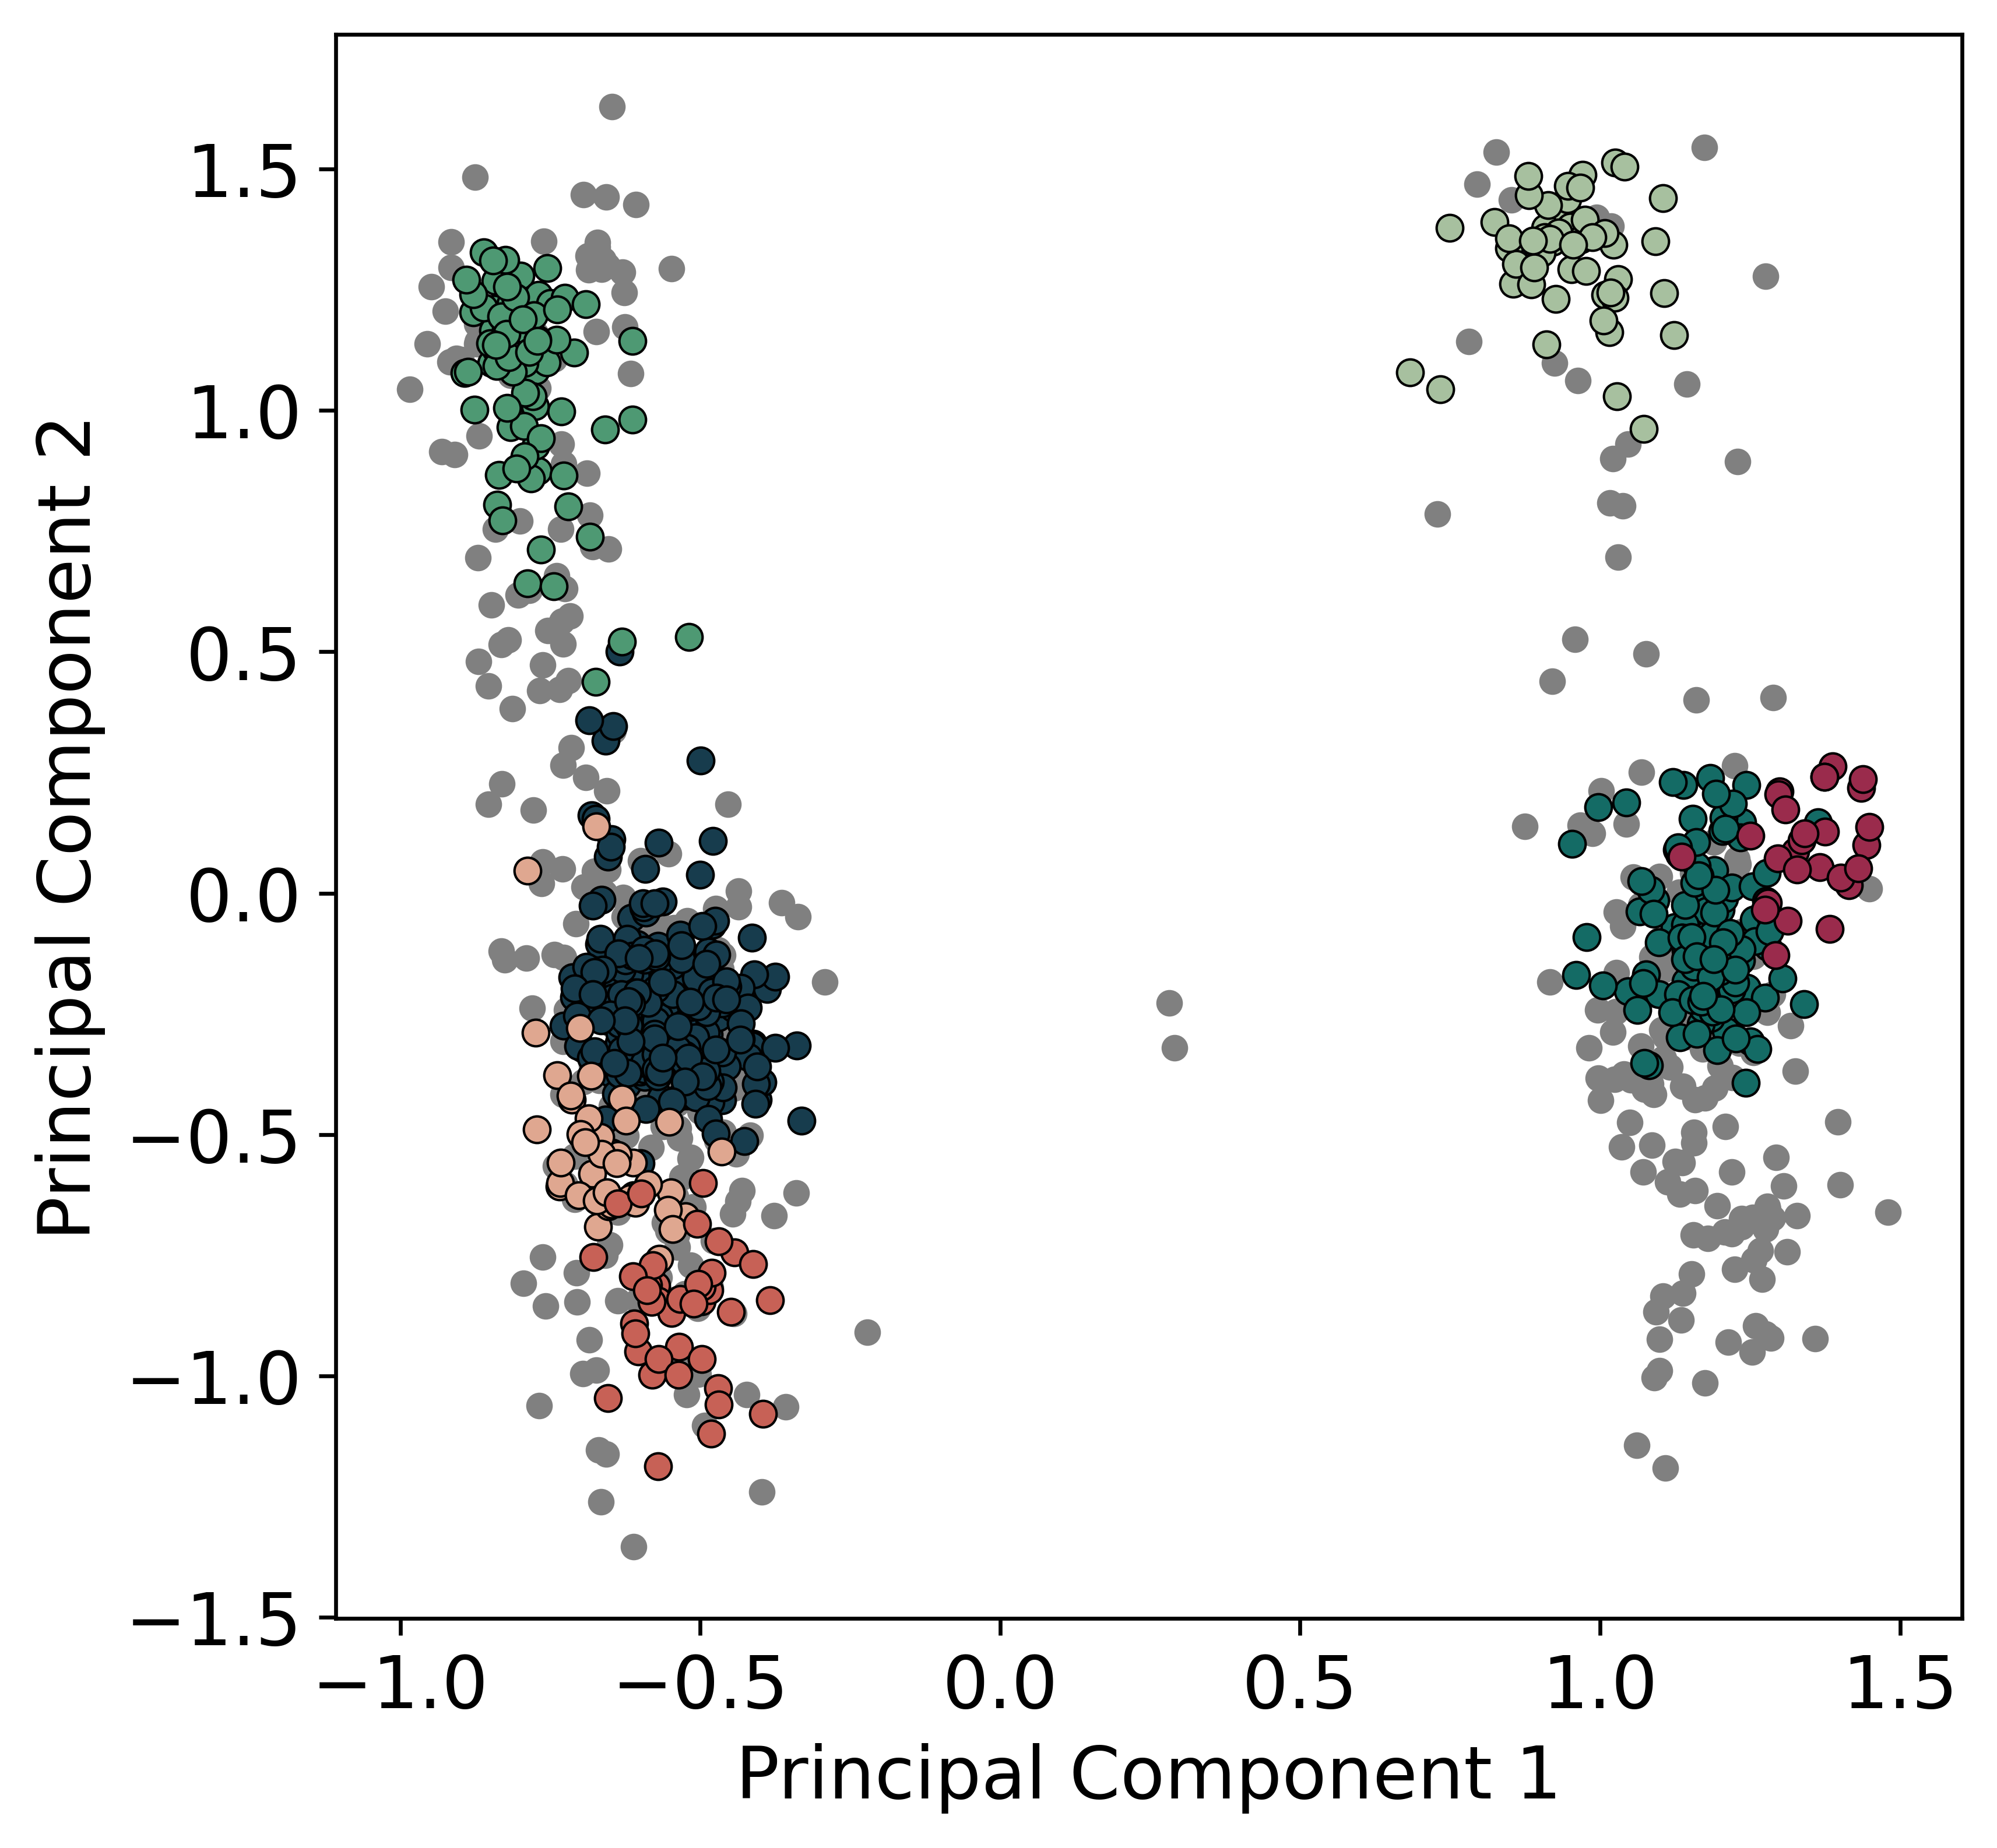

In [52]:
plt.rcParams['figure.dpi'] = 600
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)

colors = ["#173c4d","#146b65","#4e9973","#a7c09f","#dfa790","#c76156","#9a2b4c","#600b4a"]

ax.scatter(finalDf.loc[:,'principal component 1'], finalDf.loc[:,'principal component 2'], s=20, color = "gray")

for target, color in zip(targets_above,colors):
    indicesToKeep = finalDf['Conformer'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , edgecolors = "black"
               , linewidth = 0.5
               , s = 30)

ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(15)

# Perform Diffusion map

In [53]:
def dmap(data,sigma,weights=None,n=2):
    """ Dmap algorithm from Giovanni Bussi"""  
    # data[i,j]: j-th component of i-th datapoint
    # sigma: cutoff
    # weights: weight of each point
    # n: number of coordinates to extract

    # returns pair with eigenvalues and projections

    from scipy.spatial import distance
    from scipy.linalg import eigh

    dist= distance.squareform(distance.pdist(data))
    K=np.exp(-0.5*dist**2/sigma**2)
    if weights is None:
        weights=np.ones(data.shape[0])
    for i in range(1000):
        D=np.dot(K,weights)
        if np.sum((D-1)**2)<1e-14:
            break
        D=1/D**0.5
        K=np.outer(D,D)*K
    if i == 1000:
        print("warning, not converged")
    TT=np.outer(np.sqrt(weights),np.sqrt(weights))*K
    normweights=weights/np.sum(weights)
    ew,ev=eigh(TT)

    return ew[-2:-2-n:-1],ev[:,-2:-2-n:-1].T/np.sqrt(normweights)[np.newaxis]

In [54]:
sigma = 1.7

# compute first 10 components
map=dmap(x,1.7,n=10)

eigenv = map[0]
map = map[1]

## Plot Dmap

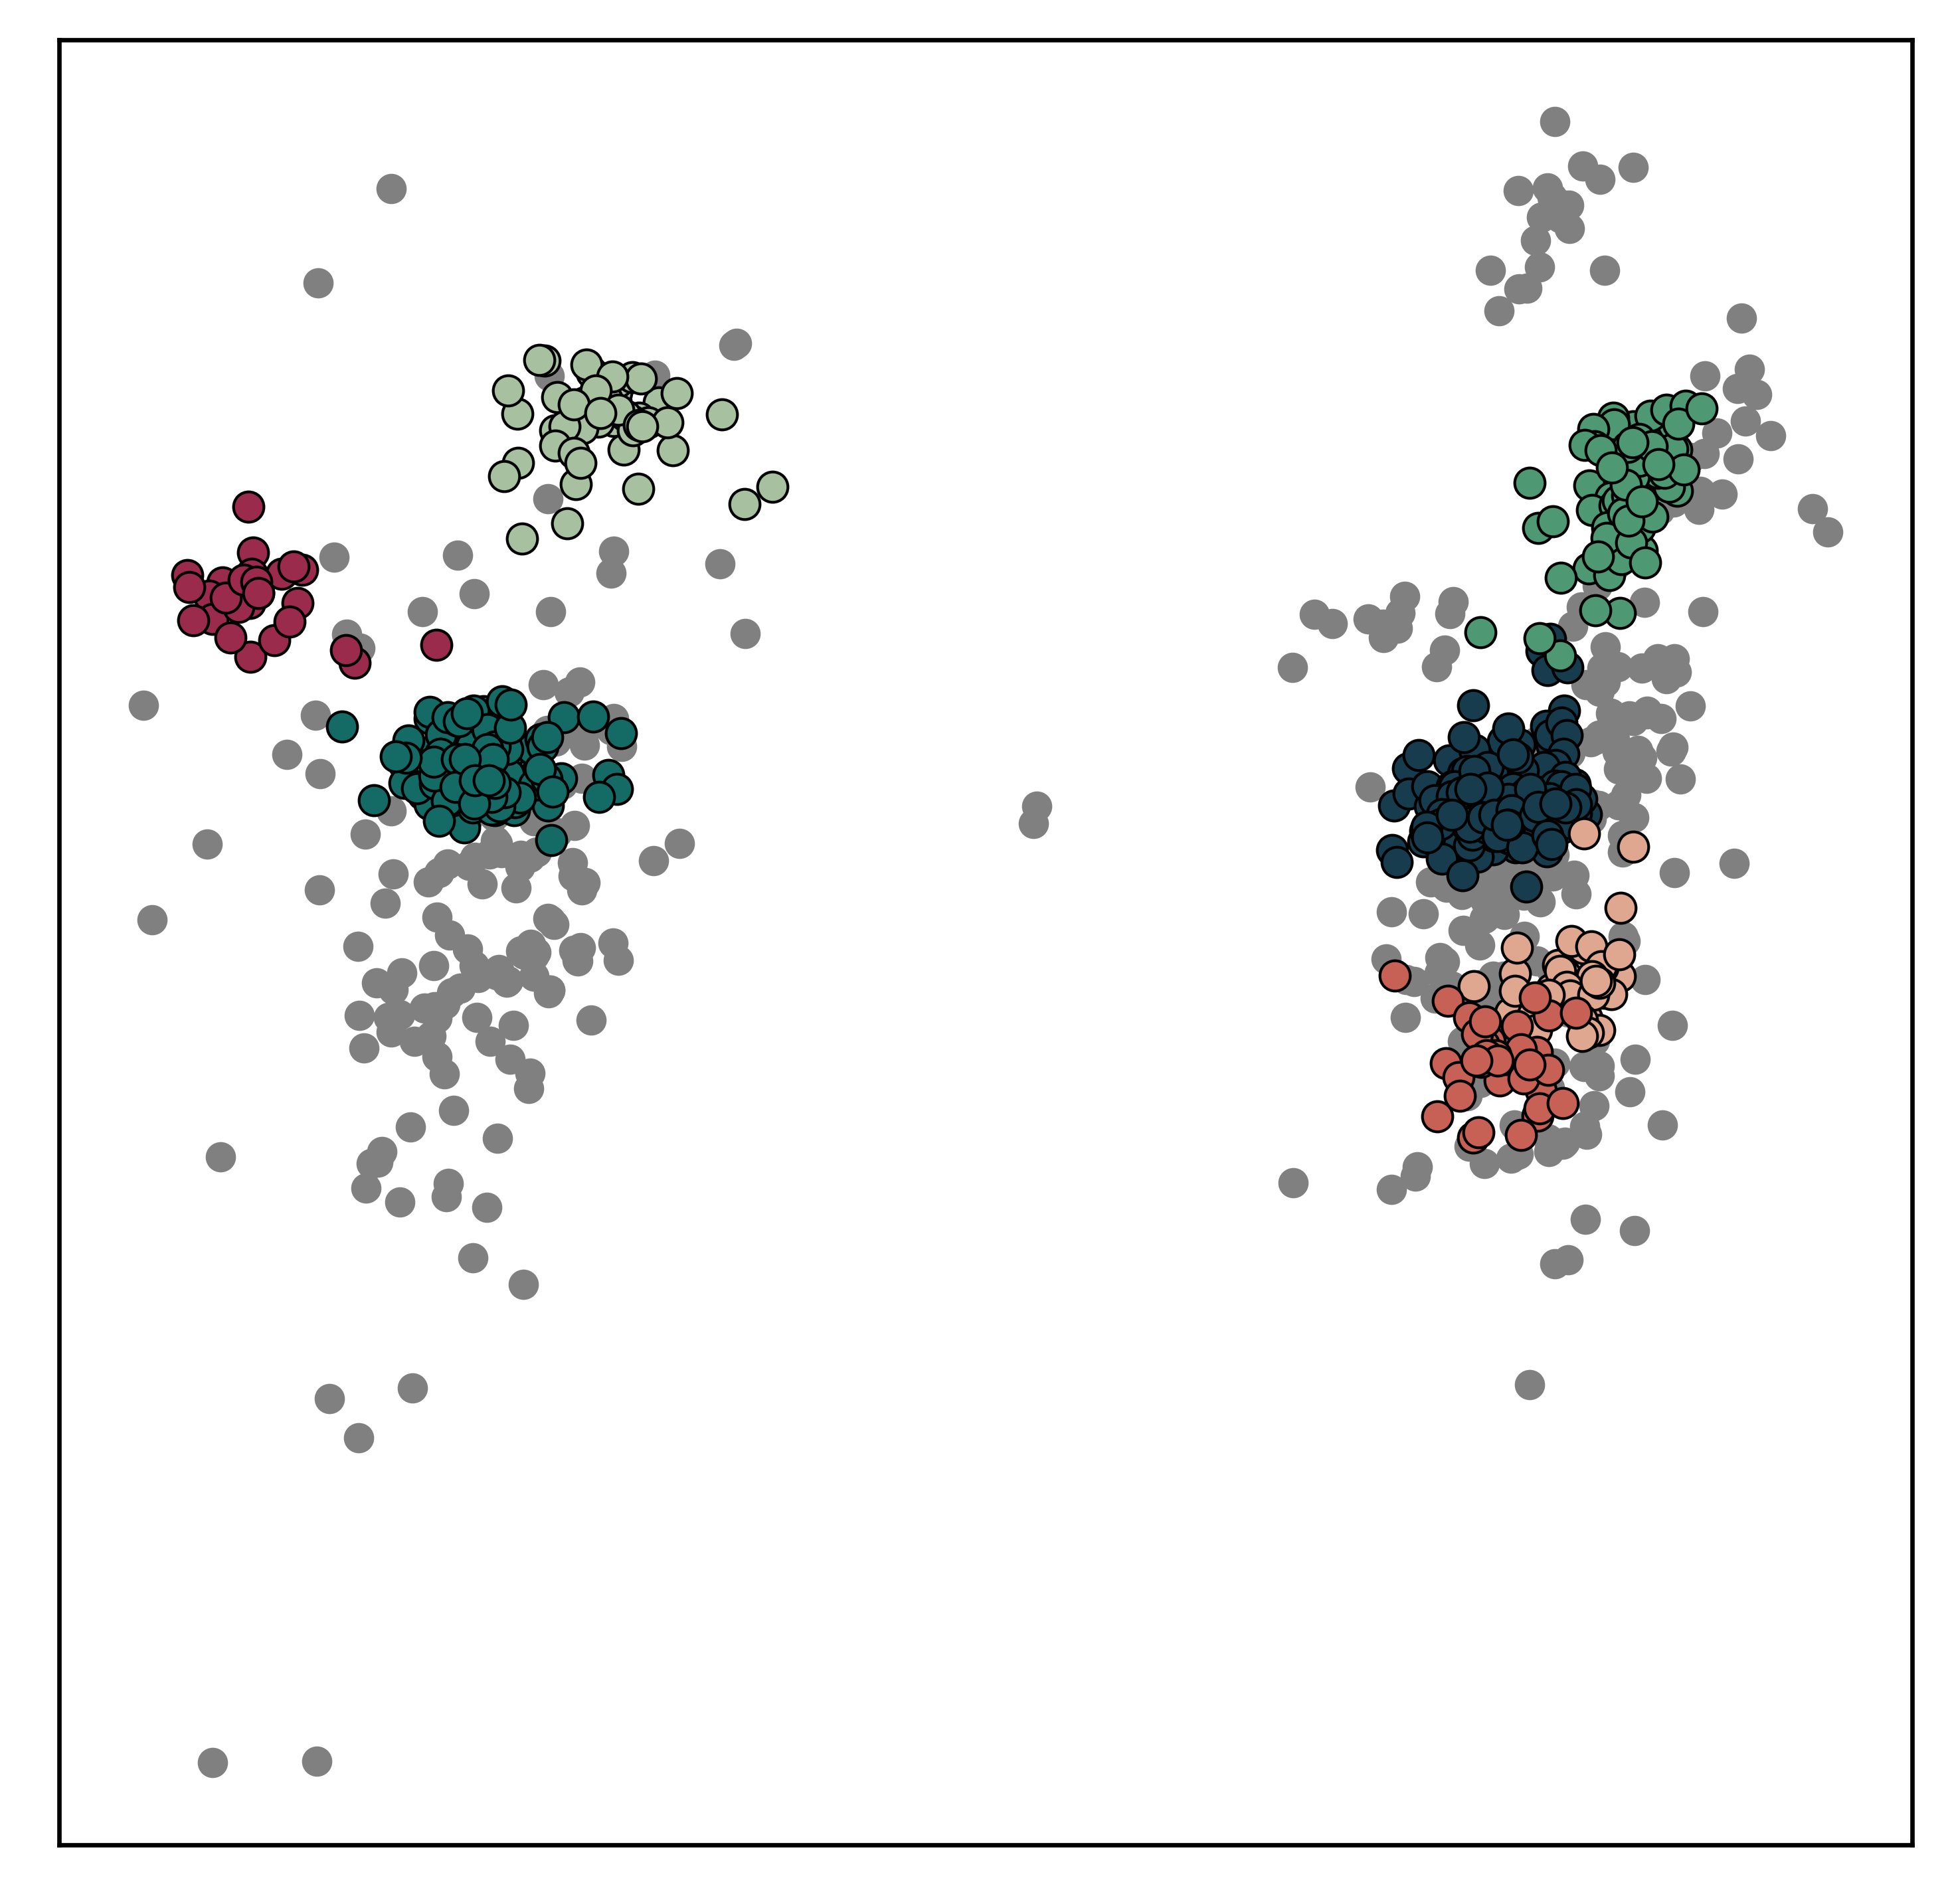

In [55]:
# Nice plotting
plt.rcParams['figure.dpi'] = 600
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1) 
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.scatter(map[0],map[1], s=20, color = "gray")

colors = ["#173c4d","#146b65","#4e9973","#a7c09f","#dfa790","#c76156","#9a2b4c","#600b4a"]

for target, color in zip(targets_above,colors):
    indicesToKeep = c_binary['Conformer'] == target
    ax.scatter(map[0][indicesToKeep]
               ,map[1][indicesToKeep]
               , c = color
               , edgecolors = "black"
               , linewidth = 0.5
               , s = 30)
ax = plt.gca()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(35)